In [8]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import csv
import gzip
import anndata as ad
from pathlib import Path
import glob

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.8.0
scanpy      1.9.1
-----
MulticoreTSNE               NA
PIL                         9.1.0
appnope                     0.1.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.0
cloudpickle                 2.1.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.9.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.8.2
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.1
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      3.0.3
joblib   

In [1]:
#pairs

#12 P'SF2990' 'SF3073'
#7 P'SF11344' 'SF12460'
#31 P'SF11916' 'SF12382')


'/Users/lidiayung/github/notebooks/GBM/Untitled Folder'

In [ ]:
'/Users/lidiayung/project/specimens/SF3076'

## Further pre-processing of expression data

In [58]:
def readann(sample):
    input_folder = "/Users/lidiayung/project/specimens"

    input_path = os.path.join(input_folder, sample) 
    #print(input_path)
    #f_anndata_path = f"{input_path}/anndata.h5ad"
    #print(f_anndata_path)
    results_file = f"{input_path}/gbm.h5ad"

    adata = sc.read(results_file)
    
    
    #pca
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    #sc.tl.paga(adata)
    #sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    #sc.tl.umap(adata, init_pos='paga')
    
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
    #sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)
    
    sc.tl.leiden(adata)
    
    sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
    
    adata.write(results_file)
    adata.raw = adata
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

    sc.settings.verbosity = 2  # reduce the verbosity

    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

    adata.write(results_file)

    sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

    pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
    
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
         for group in groups for key in ['names', 'pvals']}).head(5)
    
    sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
    sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

    sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
    
    adata = sc.read(results_file)
    
    sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)
    
    sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')




    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)
    adata.write( f_anndata_path )

    # neighborhood graph of cells (determine optimal number of PCs here)
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    # compute UMAP
    sc.tl.umap(adata)
    # tSNE
    tsne = TSNE( n_jobs=2 )
    adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
    adata.write( f_anndata_path )
    
    # cluster the neighbourhood graph
    #sc.pp.log1p(adata)
    sc.tl.louvain(adata, resolution=0.4)
    sc.pl.umap(adata, color=['louvain'] )
    
    # find marker genes
    adata.raw = adata
    sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    #sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
    #sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
    #pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
    #adata.write( f_anndata_path )
    
    nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
    nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)
    percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
    print(percentiles)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
    sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
    for i,x in enumerate(percentiles):
        fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
        ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
    ax.set_xlabel('# of genes')
    ax.set_ylabel('# of cells')
    fig.tight_layout()    

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


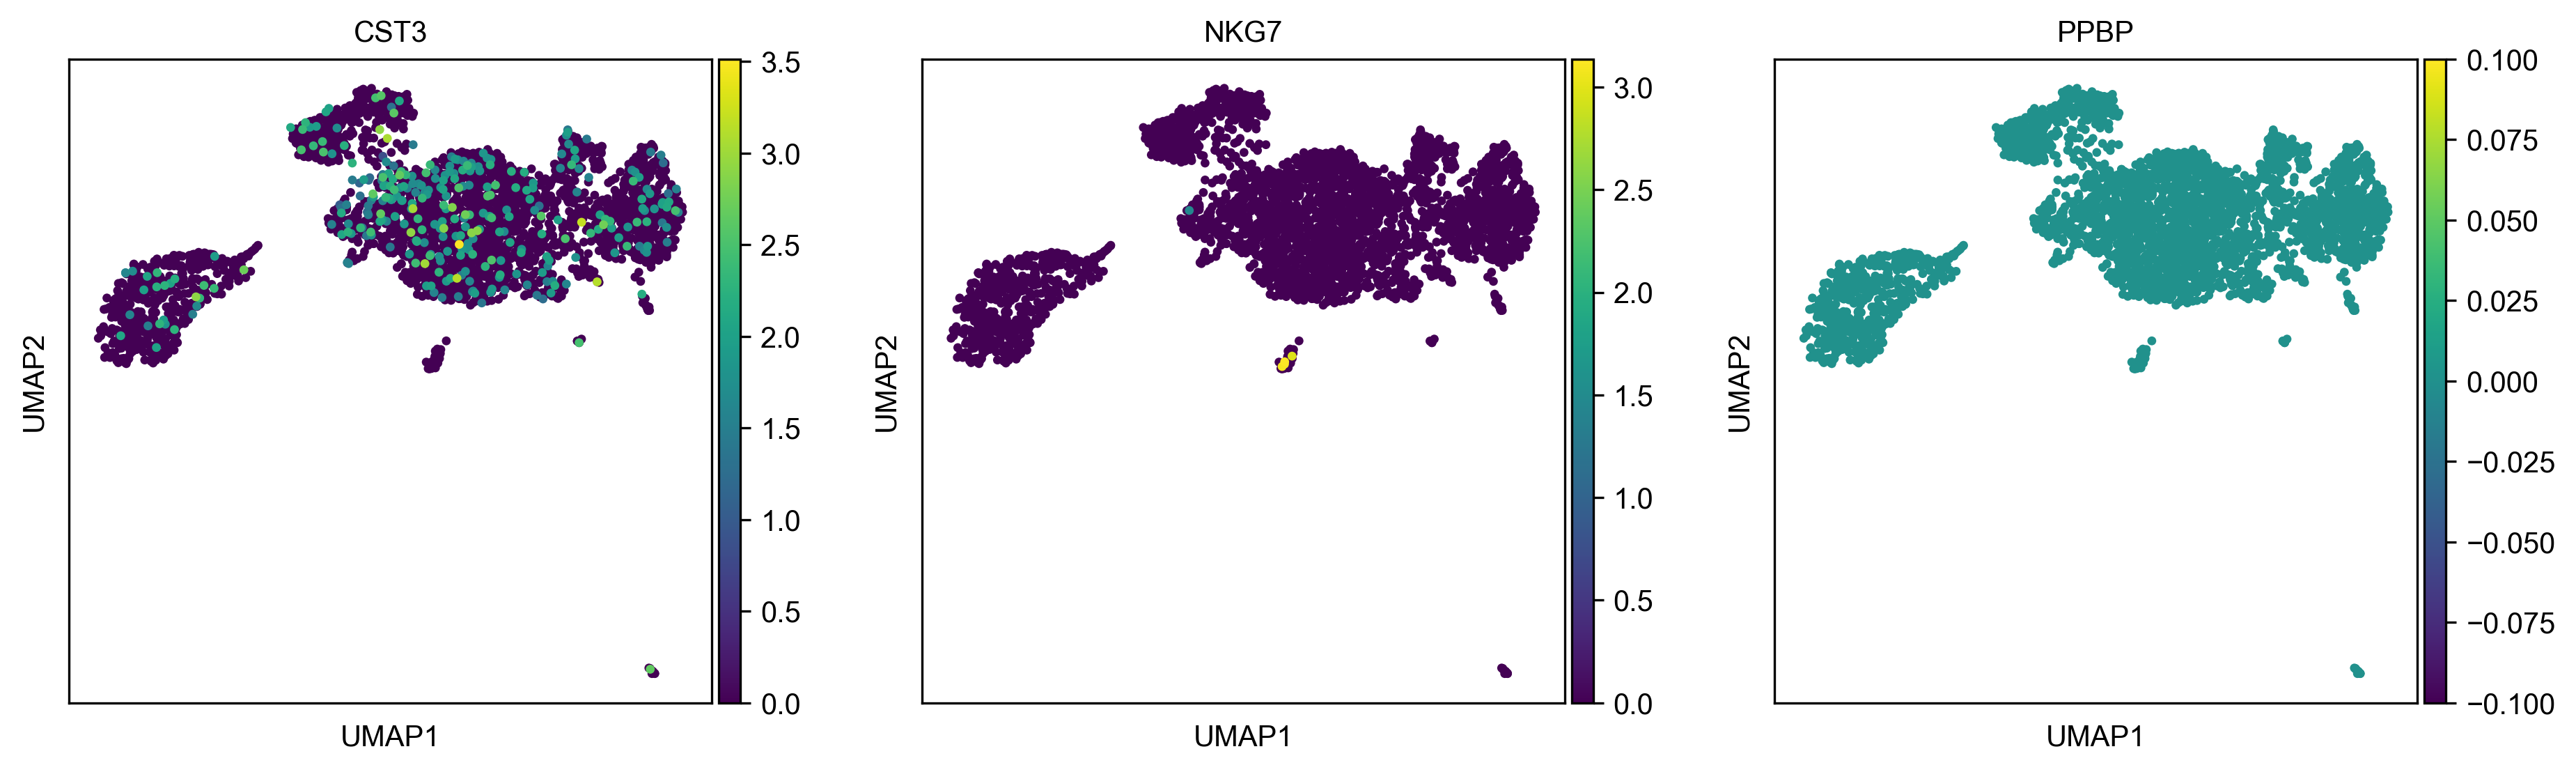

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


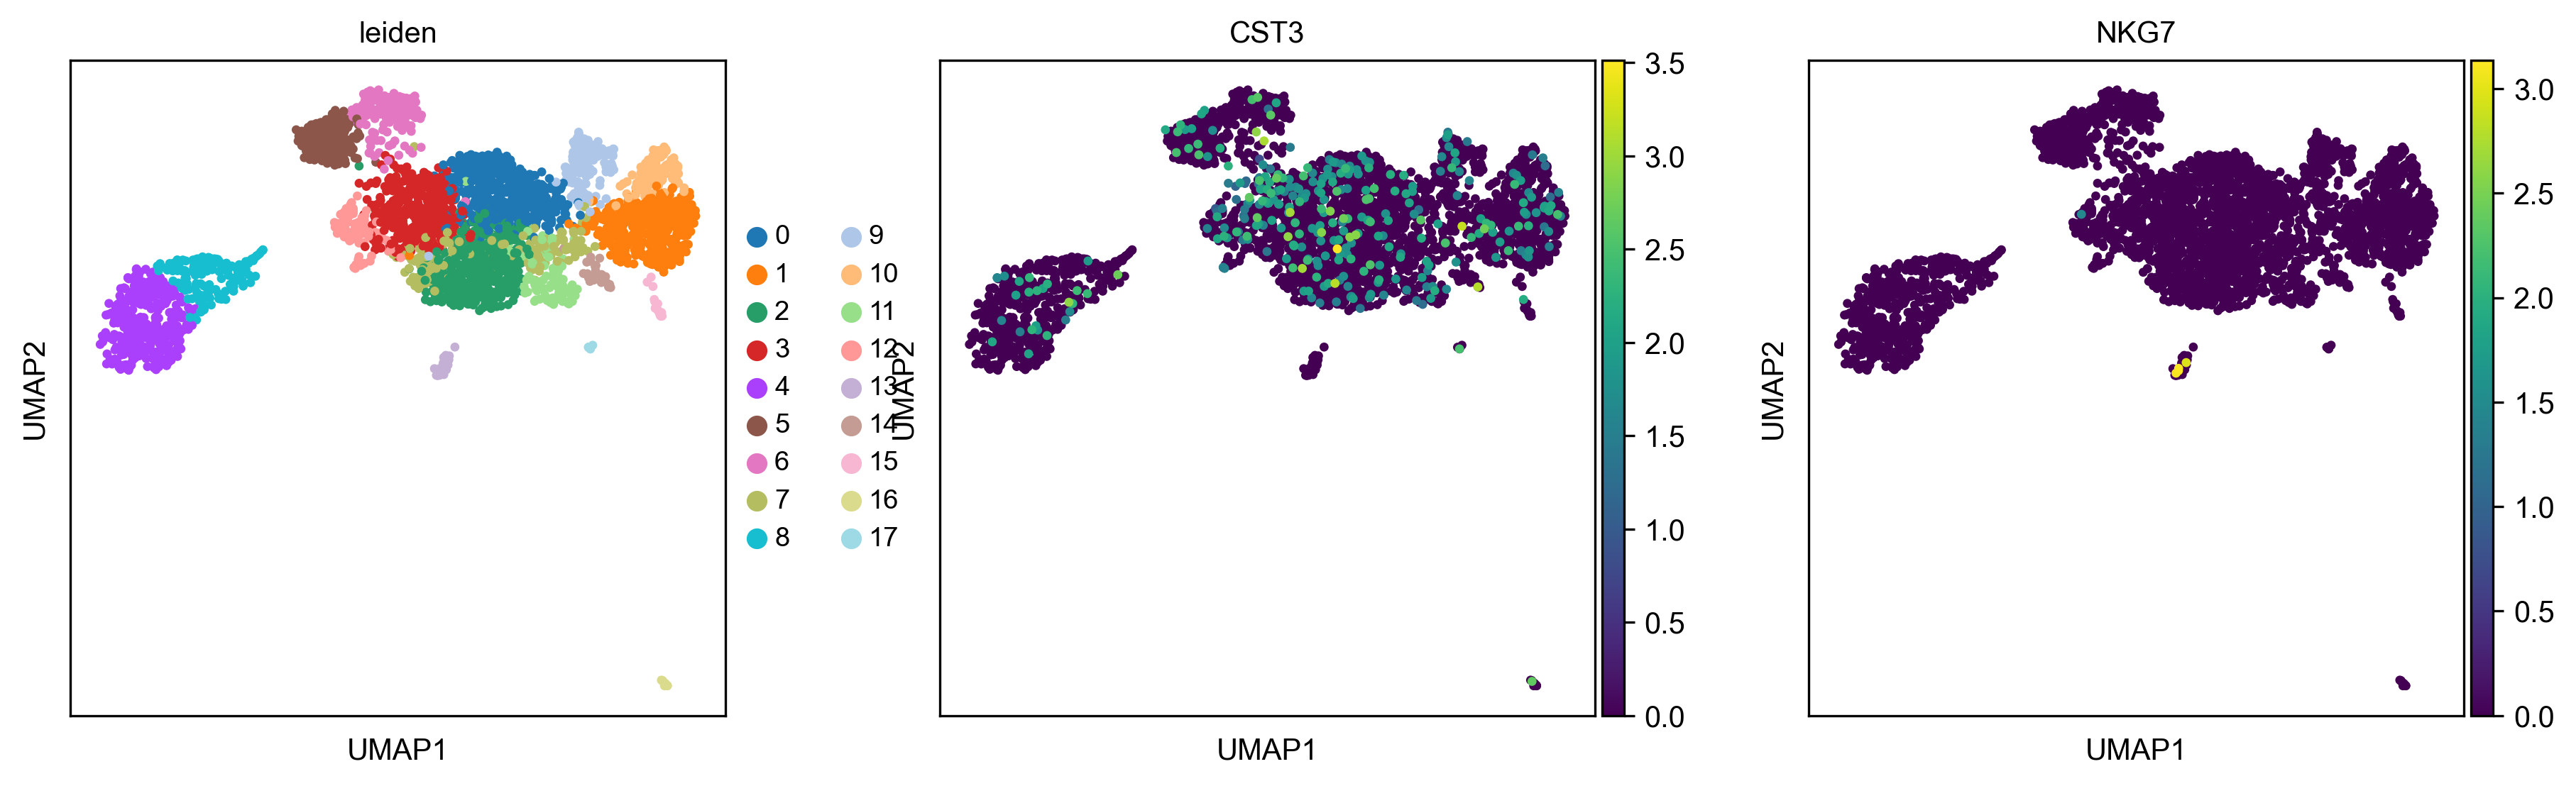

ranking genes


KeyError: 'base'

In [59]:
readann('
        ')

In [24]:
    # principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

NameError: name 'adata' is not defined

In [ ]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=2 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

In [ ]:
# cluster the neighbourhood graph
sc.tl.louvain(adata, resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

In [ ]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()